In [ ]:
# ===================== Cell 1: Imports & Config =====================
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import torch.nn.functional as F

# ========== Editable Experiment Config ==========
num_tasks = 5           # Number of tasks to split (50 classes total)
buffer_size = 2000      # Total replay / exemplar memory size
memory_batch_size = 64  # Number of replay samples per training batch (fix for NaNs)
ewc_lambda = 2500       # Regularizer strength (EWC or MAS)
use_icarl = False       # Use iCaRL memory instead of vanilla replay buffer
regularizer = 'ewc'     # 'ewc', 'mas', or None
num_epochs = 25         # Epochs per task
batch_size = 64         # Training batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print(f"Using device: {device}")


Using device: cuda


In [ ]:
# ===================== Cell 2: Dataset, Data Utilities =====================
class TransformedSubset(Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.dataset[self.indices[idx]]
        return (self.transform(x) if self.transform else x), y

    def __len__(self):
        return len(self.indices)

class CIFAR50Incremental:
    def __init__(self, root='./data', num_tasks=5, initial_shuffle=True):
        self.root = root
        self.num_tasks = num_tasks
        self.classes_per_task = 50 // num_tasks
        self.total_classes = 50

        self.train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
        ])
        self.test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
        ])

        full_train = datasets.CIFAR100(root=root, train=True, download=True)
        full_test = datasets.CIFAR100(root=root, train=False, download=True)
        selected_classes = np.arange(50)
        train_idx = [i for i, (_, y) in enumerate(full_train) if y in selected_classes]
        test_idx = [i for i, (_, y) in enumerate(full_test) if y in selected_classes]

        self.base_train = TransformedSubset(full_train, train_idx)
        self.base_test = TransformedSubset(full_test, test_idx)

        self.class_order = np.arange(50)
        if initial_shuffle:
            np.random.shuffle(self.class_order)

    def get_task_data(self, task_id):
        assert 0 <= task_id < self.num_tasks
        start = task_id * self.classes_per_task
        end = (task_id + 1) * self.classes_per_task
        task_classes = self.class_order[start:end]

        train_mask = np.isin(np.array([y for _, y in self.base_train]), task_classes)
        test_mask = np.isin(np.array([y for _, y in self.base_test]), task_classes)

        train_subset = TransformedSubset(self.base_train, np.where(train_mask)[0], self.train_transform)
        test_subset = TransformedSubset(self.base_test, np.where(test_mask)[0], self.test_transform)
        return train_subset, test_subset, task_classes


In [ ]:
# ===================== Cell 3: Model (ResNet18 w/ Attention) =====================
class AttentionLayer(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(features, features//4),
            nn.ReLU(),
            nn.Linear(features//4, features),
            nn.Sigmoid()
        )
    def forward(self, x):
        attn_weights = self.attention(x.mean(dim=[2,3]))
        return x * attn_weights.unsqueeze(-1).unsqueeze(-1)

class AttnBasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.attn = AttentionLayer(planes * self.expansion)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return self.attn(out)

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=50):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18(num_classes=50):
    return ResNet(AttnBasicBlock, [2, 2, 2, 2], num_classes)


In [ ]:
# ===================== Cell 4: Replay & Exemplar Memory =====================
class ReplayBuffer:
    def __init__(self, buffer_size=2000):
        self.buffer_size = buffer_size
        self.images, self.labels = [], []
    def add(self, x, y):
        for xi, yi in zip(x, y):
            if len(self.images) < self.buffer_size:
                self.images.append(xi.cpu() if xi.is_cuda else xi)
                self.labels.append(int(yi))
            else:
                idx = np.random.randint(0, self.buffer_size)
                self.images[idx] = xi.cpu() if xi.is_cuda else xi
                self.labels[idx] = int(yi)
    def sample(self, n):
        if len(self.images) == 0:
            return [], []
        idxs = np.random.choice(len(self.images), n, replace=len(self.images)<n)
        xs = torch.stack([self.images[i] for i in idxs])
        ys = torch.tensor([self.labels[i] for i in idxs])
        return xs, ys

class iCaRLExemplarMemory:
    def __init__(self, memory_size, feature_extractor):
        self.memory_size = memory_size
        self.feature_extractor = feature_extractor
        self.exemplar_sets = defaultdict(list)
        self.class_order = []
    def construct_exemplar_set(self, loader, class_label, m):
        X = []
        for x, y in loader:
            if y[0] == class_label:
                X.append(x.to(device))
        if len(X) == 0: return
        feats = torch.cat([self.feature_extractor(x.unsqueeze(0)) for x in X], 0)
        class_mean = feats.mean(0)
        selected, mean_so_far = [], torch.zeros_like(class_mean)
        for _ in range(m):
            remain = [i for i in range(len(X)) if i not in selected]
            best_i, min_dist = None, float('inf')
            for i in remain:
                candidate = (mean_so_far + feats[i]) / (len(selected) + 1)
                dist = torch.norm(class_mean - candidate)
                if dist < min_dist:
                    best_i, min_dist = i, dist
            selected.append(best_i)
            mean_so_far += feats[best_i]
        self.exemplar_sets[class_label] = [X[i].cpu() for i in selected]
    def reduce(self, new_total):
        per_class = max(1, new_total // max(1, len(self.exemplar_sets)))
        for cls in self.exemplar_sets:
            self.exemplar_sets[cls] = self.exemplar_sets[cls][:per_class]
    def get_all(self, n=memory_batch_size):
        exemplars, labels = [], []
        for cls in self.exemplar_sets:
            exemplars += self.exemplar_sets[cls]
            labels += [cls]*len(self.exemplar_sets[cls])
        if len(exemplars) == 0:
            return [], []
        idxs = np.random.choice(len(exemplars), min(n, len(exemplars)), replace=False)
        ex = [exemplars[i] for i in idxs]
        ey = [labels[i] for i in idxs]
        return ex, ey


In [ ]:
# ===================== Cell 5: Regularizers: EWC, MAS =====================
class EnhancedEWC:
    def __init__(self, model, dataloader, device):
        self.model = model
        self.device = device
        self.importance = {}
        self.params = {n: p.detach().clone() for n, p in model.named_parameters() if p.requires_grad}
        self.compute_fisher(dataloader)
    def compute_fisher(self, dataloader):
        fisher = {n: torch.zeros_like(p) for n,p in self.model.named_parameters() if p.requires_grad}
        self.model.eval()
        for inputs, targets in tqdm(dataloader, desc="EWC Fisher"):
            inputs,targets = inputs.to(self.device), targets.to(self.device)
            self.model.zero_grad()
            outputs = self.model(inputs)
            loss = F.cross_entropy(outputs, targets)
            loss.backward()
            for n,p in self.model.named_parameters():
                if p.grad is not None: fisher[n] += p.grad.data.pow(2) / len(dataloader)
        self.importance = fisher
    def penalty(self, model, lambda_=ewc_lambda):
        loss = 0
        for n, p in model.named_parameters():
            if n in self.importance:
                loss += (self.importance[n] * (p - self.params[n]).pow(2)).sum()
        return lambda_ * loss

class MAS:
    def __init__(self, model, dataloader, device):
        self.model = model
        self.device = device
        self.importance = self.compute_importance(dataloader)
        self.params = {n: p.detach().clone() for n,p in model.named_parameters() if p.requires_grad}
    def compute_importance(self, dataloader):
        importance = {n: torch.zeros_like(p) for n,p in self.model.named_parameters() if p.requires_grad}
        self.model.eval()
        for x, _ in tqdm(dataloader, desc="MAS importance"):
            x = x.to(self.device)
            self.model.zero_grad()
            outputs = self.model(x)
            outputs.abs().sum().backward()
            for n,p in self.model.named_parameters():
                if p.grad is not None: importance[n] += p.grad.abs() / len(dataloader)
        return importance
    def penalty(self, model, lambda_=ewc_lambda):
        loss = 0
        for n, p in model.named_parameters():
            loss += (self.importance[n] * (p-self.params[n]).pow(2)).sum()
        return lambda_ * loss


In [ ]:
# ===================== Cell 6: Training/Eval Functions (Fixed Memory Sampling + Debug) =====================
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return 100.*correct/total if total > 0 else 0.0

def train_task(student, optimizer, loader, memory, teacher, reg, task_id, num_tasks):
    student.train()
    for epoch in range(num_epochs):
        running_loss, correct, total = 0., 0, 0
        total_batches = 0
        for x, y in tqdm(loader, desc=f'Task {task_id+1} Epoch {epoch+1}'):
            x, y = x.to(device), y.to(device)
            # Sample limited replay memory for this batch
            if memory is not None and (hasattr(memory, 'get_all') or hasattr(memory, 'sample')):
                if use_icarl and hasattr(memory, 'get_all'):
                    ex, ey = memory.get_all(n=memory_batch_size)
                    if ex:
                        ex = torch.stack(ex).to(device)
                        ey = torch.tensor(ey).to(device)
                        x = torch.cat([x, ex], dim=0)
                        y = torch.cat([y, ey], dim=0)
                elif hasattr(memory, 'sample'):
                    ex, ey = memory.sample(memory_batch_size)
                    if len(ex):
                        x = torch.cat([x, ex.to(device)], dim=0)
                        y = torch.cat([y, ey.to(device)], dim=0)

            # Check label range
            if y.max() >= student.linear.out_features:
                print(f"Label out of range ({y.max().item()}) for classifier of size {student.linear.out_features}! Skipping batch.")
                continue
            # Check NaNs in input/output
            with torch.no_grad():
                if torch.isnan(x).any() or torch.isnan(y).any():
                    print("NaN detected in inputs or targets. Skipping batch.")
                    continue
            out = student(x)
            if torch.isnan(out).any():
                print("NaN detected in outputs. Skipping batch.")
                continue

            ce_loss = F.cross_entropy(out, y)
            kd_loss = 0
            if teacher is not None:
                with torch.no_grad():
                    t_logits = teacher(x)
                T = 2
                kd_loss = F.kl_div(F.log_softmax(out/T, dim=1), F.softmax(t_logits/T, dim=1), reduction='batchmean') * T*T

            loss = 0.5 * ce_loss + 0.5 * kd_loss
            # if reg is not None:
            #     loss += reg.penalty(student, lambda_=ewc_lambda)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, pred = out.max(1)
            total += y.size(0)
            correct += (pred == y).sum().item()
            total_batches += 1

        if total_batches == 0:
            print(f"Epoch {epoch+1}: No valid batches run!")
        else:
            print(f"Epoch {epoch+1}: Loss={running_loss/total_batches:.4f}, Acc={100.*correct/total:.2f}%")


100%|██████████| 169M/169M [00:04<00:00, 35.2MB/s]


Debug - Task 0 classes: [13 39 30 45 17 48 26 25 32 19]
Debug - Train samples: 5000, Test samples: 1000
Debug - Sample labels: tensor([19, 39, 17, 39, 17, 45, 39, 39, 32, 30])

=== Task 1/5 ===


Task 1 Epoch 1: 100%|██████████| 79/79 [00:14<00:00,  5.63it/s]


Epoch 1: Loss=1.3183, Acc=39.70%


Task 1 Epoch 2: 100%|██████████| 79/79 [00:12<00:00,  6.18it/s]


Epoch 2: Loss=0.9679, Acc=66.48%


Task 1 Epoch 3: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 3: Loss=0.8255, Acc=75.64%


Task 1 Epoch 4: 100%|██████████| 79/79 [00:12<00:00,  6.09it/s]


Epoch 4: Loss=0.7584, Acc=79.74%


Task 1 Epoch 5: 100%|██████████| 79/79 [00:13<00:00,  6.05it/s]


Epoch 5: Loss=0.7245, Acc=81.59%


Task 1 Epoch 6: 100%|██████████| 79/79 [00:13<00:00,  5.98it/s]


Epoch 6: Loss=0.6903, Acc=83.80%


Task 1 Epoch 7: 100%|██████████| 79/79 [00:13<00:00,  5.92it/s]


Epoch 7: Loss=0.6679, Acc=85.44%


Task 1 Epoch 8: 100%|██████████| 79/79 [00:13<00:00,  5.86it/s]


Epoch 8: Loss=0.6535, Acc=86.25%


Task 1 Epoch 9: 100%|██████████| 79/79 [00:13<00:00,  5.85it/s]


Epoch 9: Loss=0.6326, Acc=87.65%


Task 1 Epoch 10: 100%|██████████| 79/79 [00:13<00:00,  5.87it/s]


Epoch 10: Loss=0.6146, Acc=88.73%


Task 1 Epoch 11: 100%|██████████| 79/79 [00:13<00:00,  5.89it/s]


Epoch 11: Loss=0.6082, Acc=89.10%


Task 1 Epoch 12: 100%|██████████| 79/79 [00:13<00:00,  5.94it/s]


Epoch 12: Loss=0.6005, Acc=89.38%


Task 1 Epoch 13: 100%|██████████| 79/79 [00:13<00:00,  5.89it/s]


Epoch 13: Loss=0.5885, Acc=90.69%


Task 1 Epoch 14: 100%|██████████| 79/79 [00:13<00:00,  5.88it/s]


Epoch 14: Loss=0.5751, Acc=91.60%


Task 1 Epoch 15: 100%|██████████| 79/79 [00:13<00:00,  5.88it/s]


Epoch 15: Loss=0.5704, Acc=91.69%


Task 1 Epoch 16: 100%|██████████| 79/79 [00:13<00:00,  5.84it/s]


Epoch 16: Loss=0.5636, Acc=92.30%


Task 1 Epoch 17: 100%|██████████| 79/79 [00:13<00:00,  5.89it/s]


Epoch 17: Loss=0.5539, Acc=92.93%


Task 1 Epoch 18: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 18: Loss=0.5460, Acc=93.37%


Task 1 Epoch 19: 100%|██████████| 79/79 [00:13<00:00,  5.89it/s]


Epoch 19: Loss=0.5366, Acc=94.04%


Task 1 Epoch 20: 100%|██████████| 79/79 [00:13<00:00,  5.89it/s]


Epoch 20: Loss=0.5346, Acc=94.12%


Task 1 Epoch 21: 100%|██████████| 79/79 [00:13<00:00,  5.88it/s]


Epoch 21: Loss=0.5273, Acc=94.75%


Task 1 Epoch 22: 100%|██████████| 79/79 [00:13<00:00,  5.87it/s]


Epoch 22: Loss=0.5202, Acc=95.07%


Task 1 Epoch 23: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 23: Loss=0.5229, Acc=94.97%


Task 1 Epoch 24: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 24: Loss=0.5163, Acc=95.61%


Task 1 Epoch 25: 100%|██████████| 79/79 [00:13<00:00,  5.85it/s]


Epoch 25: Loss=0.5145, Acc=95.50%
Accuracy on Task 1: 66.10%

=== Task 2/5 ===


Task 2 Epoch 1: 100%|██████████| 79/79 [00:13<00:00,  5.89it/s]


Epoch 1: Loss=1.1330, Acc=54.88%


Task 2 Epoch 2: 100%|██████████| 79/79 [00:13<00:00,  5.89it/s]


Epoch 2: Loss=0.7611, Acc=83.28%


Task 2 Epoch 3: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 3: Loss=0.6747, Acc=87.82%


Task 2 Epoch 4: 100%|██████████| 79/79 [00:13<00:00,  5.84it/s]


Epoch 4: Loss=0.6366, Acc=89.85%


Task 2 Epoch 5: 100%|██████████| 79/79 [00:13<00:00,  5.91it/s]


Epoch 5: Loss=0.6042, Acc=91.50%


Task 2 Epoch 6: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 6: Loss=0.5880, Acc=92.29%


Task 2 Epoch 7: 100%|██████████| 79/79 [00:13<00:00,  5.91it/s]


Epoch 7: Loss=0.5750, Acc=93.34%


Task 2 Epoch 8: 100%|██████████| 79/79 [00:13<00:00,  5.88it/s]


Epoch 8: Loss=0.5620, Acc=94.06%


Task 2 Epoch 9: 100%|██████████| 79/79 [00:13<00:00,  5.86it/s]


Epoch 9: Loss=0.5507, Acc=94.63%


Task 2 Epoch 10: 100%|██████████| 79/79 [00:13<00:00,  5.89it/s]


Epoch 10: Loss=0.5377, Acc=95.20%


Task 2 Epoch 11: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 11: Loss=0.5292, Acc=95.54%


Task 2 Epoch 12: 100%|██████████| 79/79 [00:13<00:00,  5.89it/s]


Epoch 12: Loss=0.5273, Acc=95.87%


Task 2 Epoch 13: 100%|██████████| 79/79 [00:13<00:00,  5.91it/s]


Epoch 13: Loss=0.5181, Acc=96.11%


Task 2 Epoch 14: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 14: Loss=0.5097, Acc=96.61%


Task 2 Epoch 15: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 15: Loss=0.5138, Acc=96.60%


Task 2 Epoch 16: 100%|██████████| 79/79 [00:13<00:00,  5.89it/s]


Epoch 16: Loss=0.5059, Acc=96.91%


Task 2 Epoch 17: 100%|██████████| 79/79 [00:13<00:00,  5.83it/s]


Epoch 17: Loss=0.4991, Acc=97.32%


Task 2 Epoch 18: 100%|██████████| 79/79 [00:13<00:00,  5.89it/s]


Epoch 18: Loss=0.4996, Acc=97.16%


Task 2 Epoch 19: 100%|██████████| 79/79 [00:13<00:00,  5.91it/s]


Epoch 19: Loss=0.4901, Acc=97.87%


Task 2 Epoch 20: 100%|██████████| 79/79 [00:13<00:00,  5.89it/s]


Epoch 20: Loss=0.4838, Acc=98.01%


Task 2 Epoch 21: 100%|██████████| 79/79 [00:13<00:00,  5.87it/s]


Epoch 21: Loss=0.4838, Acc=98.16%


Task 2 Epoch 22: 100%|██████████| 79/79 [00:13<00:00,  5.89it/s]


Epoch 22: Loss=0.4810, Acc=98.10%


Task 2 Epoch 23: 100%|██████████| 79/79 [00:13<00:00,  5.89it/s]


Epoch 23: Loss=0.4843, Acc=97.91%


Task 2 Epoch 24: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 24: Loss=0.4879, Acc=97.66%


Task 2 Epoch 25: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 25: Loss=0.4840, Acc=97.93%
Accuracy on Task 1: 44.00%
Accuracy on Task 2: 83.10%

=== Task 3/5 ===


Task 3 Epoch 1: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 1: Loss=1.0324, Acc=62.38%


Task 3 Epoch 2: 100%|██████████| 79/79 [00:13<00:00,  5.91it/s]


Epoch 2: Loss=0.7050, Acc=86.48%


Task 3 Epoch 3: 100%|██████████| 79/79 [00:13<00:00,  5.86it/s]


Epoch 3: Loss=0.6347, Acc=90.38%


Task 3 Epoch 4: 100%|██████████| 79/79 [00:13<00:00,  5.86it/s]


Epoch 4: Loss=0.5952, Acc=92.07%


Task 3 Epoch 5: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 5: Loss=0.5670, Acc=93.81%


Task 3 Epoch 6: 100%|██████████| 79/79 [00:13<00:00,  5.92it/s]


Epoch 6: Loss=0.5461, Acc=94.64%


Task 3 Epoch 7: 100%|██████████| 79/79 [00:13<00:00,  5.91it/s]


Epoch 7: Loss=0.5301, Acc=95.33%


Task 3 Epoch 8: 100%|██████████| 79/79 [00:13<00:00,  5.91it/s]


Epoch 8: Loss=0.5118, Acc=96.25%


Task 3 Epoch 9: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 9: Loss=0.5033, Acc=96.90%


Task 3 Epoch 10: 100%|██████████| 79/79 [00:13<00:00,  5.89it/s]


Epoch 10: Loss=0.4953, Acc=96.83%


Task 3 Epoch 11: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 11: Loss=0.4834, Acc=97.53%


Task 3 Epoch 12: 100%|██████████| 79/79 [00:13<00:00,  5.86it/s]


Epoch 12: Loss=0.4784, Acc=97.67%


Task 3 Epoch 13: 100%|██████████| 79/79 [00:13<00:00,  5.88it/s]


Epoch 13: Loss=0.4695, Acc=98.31%


Task 3 Epoch 14: 100%|██████████| 79/79 [00:13<00:00,  5.88it/s]


Epoch 14: Loss=0.4673, Acc=98.44%


Task 3 Epoch 15: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 15: Loss=0.4656, Acc=98.23%


Task 3 Epoch 16: 100%|██████████| 79/79 [00:13<00:00,  5.91it/s]


Epoch 16: Loss=0.4676, Acc=98.15%


Task 3 Epoch 17: 100%|██████████| 79/79 [00:13<00:00,  5.91it/s]


Epoch 17: Loss=0.4588, Acc=98.55%


Task 3 Epoch 18: 100%|██████████| 79/79 [00:13<00:00,  5.89it/s]


Epoch 18: Loss=0.4535, Acc=98.73%


Task 3 Epoch 19: 100%|██████████| 79/79 [00:13<00:00,  5.87it/s]


Epoch 19: Loss=0.4576, Acc=98.77%


Task 3 Epoch 20: 100%|██████████| 79/79 [00:13<00:00,  5.89it/s]


Epoch 20: Loss=0.4509, Acc=99.03%


Task 3 Epoch 21: 100%|██████████| 79/79 [00:13<00:00,  5.87it/s]


Epoch 21: Loss=0.4504, Acc=99.09%


Task 3 Epoch 22: 100%|██████████| 79/79 [00:13<00:00,  5.87it/s]


Epoch 22: Loss=0.4513, Acc=98.96%


Task 3 Epoch 23: 100%|██████████| 79/79 [00:13<00:00,  5.84it/s]


Epoch 23: Loss=0.4478, Acc=98.96%


Task 3 Epoch 24: 100%|██████████| 79/79 [00:13<00:00,  5.88it/s]


Epoch 24: Loss=0.4513, Acc=98.84%


Task 3 Epoch 25: 100%|██████████| 79/79 [00:13<00:00,  5.87it/s]


Epoch 25: Loss=0.4470, Acc=99.13%
Accuracy on Task 1: 32.90%
Accuracy on Task 2: 57.90%
Accuracy on Task 3: 85.30%

=== Task 4/5 ===


Task 4 Epoch 1: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 1: Loss=0.9763, Acc=65.46%


Task 4 Epoch 2: 100%|██████████| 79/79 [00:13<00:00,  5.88it/s]


Epoch 2: Loss=0.6981, Acc=84.97%


Task 4 Epoch 3: 100%|██████████| 79/79 [00:13<00:00,  5.89it/s]


Epoch 3: Loss=0.6309, Acc=89.29%


Task 4 Epoch 4: 100%|██████████| 79/79 [00:13<00:00,  5.88it/s]


Epoch 4: Loss=0.5912, Acc=91.68%


Task 4 Epoch 5: 100%|██████████| 79/79 [00:13<00:00,  5.88it/s]


Epoch 5: Loss=0.5602, Acc=93.48%


Task 4 Epoch 6: 100%|██████████| 79/79 [00:13<00:00,  5.87it/s]


Epoch 6: Loss=0.5521, Acc=93.36%


Task 4 Epoch 7: 100%|██████████| 79/79 [00:13<00:00,  5.91it/s]


Epoch 7: Loss=0.5346, Acc=94.77%


Task 4 Epoch 8: 100%|██████████| 79/79 [00:13<00:00,  5.92it/s]


Epoch 8: Loss=0.5131, Acc=95.63%


Task 4 Epoch 9: 100%|██████████| 79/79 [00:13<00:00,  5.89it/s]


Epoch 9: Loss=0.5142, Acc=95.53%


Task 4 Epoch 10: 100%|██████████| 79/79 [00:13<00:00,  5.86it/s]


Epoch 10: Loss=0.4992, Acc=96.33%


Task 4 Epoch 11: 100%|██████████| 79/79 [00:13<00:00,  5.88it/s]


Epoch 11: Loss=0.4960, Acc=96.28%


Task 4 Epoch 12: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 12: Loss=0.4870, Acc=96.79%


Task 4 Epoch 13: 100%|██████████| 79/79 [00:13<00:00,  5.91it/s]


Epoch 13: Loss=0.4859, Acc=96.68%


Task 4 Epoch 14: 100%|██████████| 79/79 [00:13<00:00,  5.91it/s]


Epoch 14: Loss=0.4739, Acc=97.62%


Task 4 Epoch 15: 100%|██████████| 79/79 [00:13<00:00,  5.84it/s]


Epoch 15: Loss=0.4824, Acc=97.13%


Task 4 Epoch 16: 100%|██████████| 79/79 [00:13<00:00,  5.87it/s]


Epoch 16: Loss=0.4711, Acc=97.74%


Task 4 Epoch 17: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 17: Loss=0.4668, Acc=97.68%


Task 4 Epoch 18: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 18: Loss=0.4625, Acc=98.16%


Task 4 Epoch 19: 100%|██████████| 79/79 [00:13<00:00,  5.87it/s]


Epoch 19: Loss=0.4614, Acc=98.09%


Task 4 Epoch 20: 100%|██████████| 79/79 [00:13<00:00,  5.89it/s]


Epoch 20: Loss=0.4613, Acc=97.87%


Task 4 Epoch 21: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 21: Loss=0.4662, Acc=97.67%


Task 4 Epoch 22: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 22: Loss=0.4650, Acc=97.96%


Task 4 Epoch 23: 100%|██████████| 79/79 [00:13<00:00,  5.87it/s]


Epoch 23: Loss=0.4543, Acc=98.41%


Task 4 Epoch 24: 100%|██████████| 79/79 [00:13<00:00,  5.85it/s]


Epoch 24: Loss=0.4586, Acc=98.28%


Task 4 Epoch 25: 100%|██████████| 79/79 [00:13<00:00,  5.89it/s]


Epoch 25: Loss=0.4590, Acc=98.12%
Accuracy on Task 1: 23.40%
Accuracy on Task 2: 34.70%
Accuracy on Task 3: 54.70%
Accuracy on Task 4: 80.80%

=== Task 5/5 ===


Task 5 Epoch 1: 100%|██████████| 79/79 [00:13<00:00,  5.88it/s]


Epoch 1: Loss=1.0002, Acc=64.05%


Task 5 Epoch 2: 100%|██████████| 79/79 [00:13<00:00,  5.87it/s]


Epoch 2: Loss=0.7605, Acc=83.20%


Task 5 Epoch 3: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 3: Loss=0.6879, Acc=87.59%


Task 5 Epoch 4: 100%|██████████| 79/79 [00:13<00:00,  5.87it/s]


Epoch 4: Loss=0.6280, Acc=91.12%


Task 5 Epoch 5: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 5: Loss=0.5960, Acc=92.75%


Task 5 Epoch 6: 100%|██████████| 79/79 [00:13<00:00,  5.91it/s]


Epoch 6: Loss=0.5536, Acc=94.61%


Task 5 Epoch 7: 100%|██████████| 79/79 [00:13<00:00,  5.86it/s]


Epoch 7: Loss=0.5398, Acc=94.93%


Task 5 Epoch 8: 100%|██████████| 79/79 [00:13<00:00,  5.88it/s]


Epoch 8: Loss=0.5238, Acc=96.05%


Task 5 Epoch 9: 100%|██████████| 79/79 [00:13<00:00,  5.91it/s]


Epoch 9: Loss=0.5120, Acc=96.39%


Task 5 Epoch 10: 100%|██████████| 79/79 [00:13<00:00,  5.88it/s]


Epoch 10: Loss=0.5028, Acc=96.69%


Task 5 Epoch 11: 100%|██████████| 79/79 [00:13<00:00,  5.88it/s]


Epoch 11: Loss=0.4957, Acc=96.98%


Task 5 Epoch 12: 100%|██████████| 79/79 [00:13<00:00,  5.89it/s]


Epoch 12: Loss=0.4808, Acc=97.75%


Task 5 Epoch 13: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 13: Loss=0.4789, Acc=97.79%


Task 5 Epoch 14: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 14: Loss=0.4860, Acc=97.31%


Task 5 Epoch 15: 100%|██████████| 79/79 [00:13<00:00,  5.89it/s]


Epoch 15: Loss=0.4845, Acc=97.52%


Task 5 Epoch 16: 100%|██████████| 79/79 [00:13<00:00,  5.86it/s]


Epoch 16: Loss=0.4713, Acc=98.08%


Task 5 Epoch 17: 100%|██████████| 79/79 [00:13<00:00,  5.87it/s]


Epoch 17: Loss=0.4700, Acc=98.02%


Task 5 Epoch 18: 100%|██████████| 79/79 [00:13<00:00,  5.89it/s]


Epoch 18: Loss=0.4625, Acc=98.56%


Task 5 Epoch 19: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 19: Loss=0.4684, Acc=97.98%


Task 5 Epoch 20: 100%|██████████| 79/79 [00:13<00:00,  5.88it/s]


Epoch 20: Loss=0.4572, Acc=98.60%


Task 5 Epoch 21: 100%|██████████| 79/79 [00:13<00:00,  5.91it/s]


Epoch 21: Loss=0.4563, Acc=98.67%


Task 5 Epoch 22: 100%|██████████| 79/79 [00:13<00:00,  5.92it/s]


Epoch 22: Loss=0.4536, Acc=98.82%


Task 5 Epoch 23: 100%|██████████| 79/79 [00:13<00:00,  5.91it/s]


Epoch 23: Loss=0.4499, Acc=98.89%


Task 5 Epoch 24: 100%|██████████| 79/79 [00:13<00:00,  5.91it/s]


Epoch 24: Loss=0.4541, Acc=98.79%


Task 5 Epoch 25: 100%|██████████| 79/79 [00:13<00:00,  5.85it/s]


Epoch 25: Loss=0.4601, Acc=98.30%
Accuracy on Task 1: 16.10%
Accuracy on Task 2: 24.80%
Accuracy on Task 3: 39.60%
Accuracy on Task 4: 53.80%
Accuracy on Task 5: 80.60%


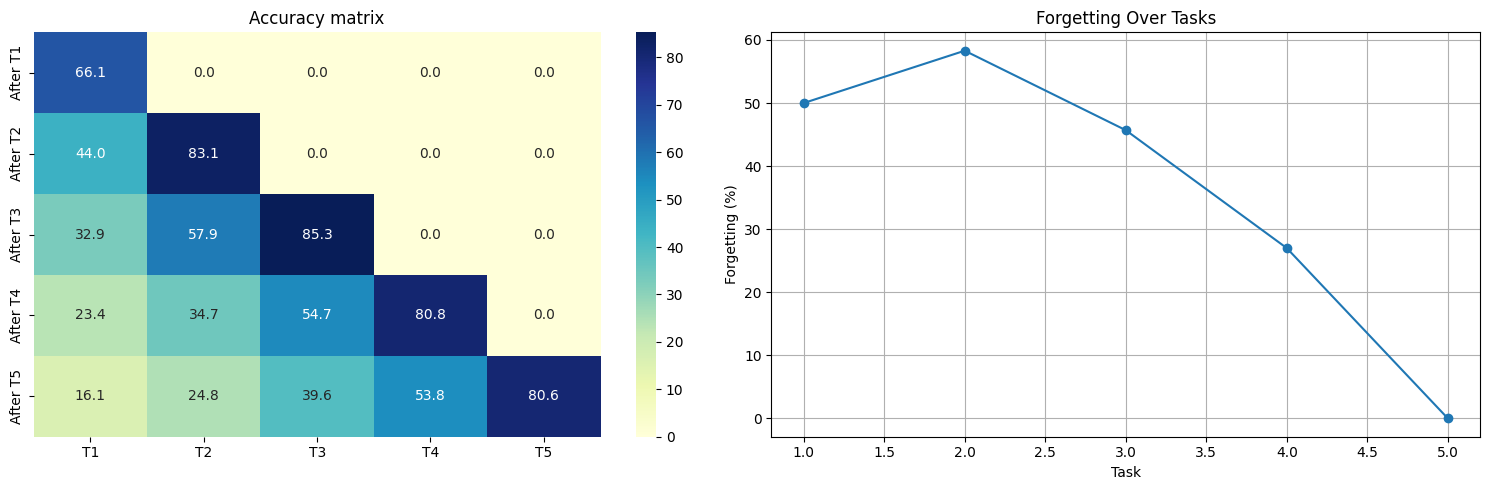

In [ ]:
# ===================== Cell 7: Main Loop & Plot =====================
def main():
    dataset = CIFAR50Incremental(num_tasks=num_tasks)
    student = ResNet18(num_classes=50).to(device)
    teacher = None

    if use_icarl:
        # Feature extractor is all layers except the final linear
        feature_extractor = nn.Sequential(*(list(student.children())[:-1])).to(device)
        memory = iCaRLExemplarMemory(memory_size=buffer_size, feature_extractor=feature_extractor)
    else:
        memory = ReplayBuffer(buffer_size=buffer_size)

    acc_matrix = np.zeros((num_tasks, num_tasks))
    max_acc = [0]*num_tasks

    for task_id in range(num_tasks):
        print(f"\n=== Task {task_id+1}/{num_tasks} ===")
        train_set, test_set, task_classes = dataset.get_task_data(task_id)
        tr_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        te_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

        # Populate memory buffer / iCaRL exemplars
        if use_icarl:
            student.eval()
            for c in task_classes:
                cls_loader = DataLoader([d for d in train_set if d[1] == c], batch_size=1)
                memory.construct_exemplar_set(cls_loader, int(c), max(1, buffer_size // ((task_id + 1)*len(task_classes))))
            memory.reduce(buffer_size)
        else:
            for i in range(min(buffer_size // num_tasks, len(train_set))):
                xi, yi = train_set[i]
                memory.add([xi], [yi])

        optimizer = optim.SGD(student.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
        reg = None
        if regularizer == 'ewc' and task_id > 0:
            reg = EnhancedEWC(student, tr_loader, device)
        elif regularizer == 'mas' and task_id > 0:
            reg = MAS(student, tr_loader, device)

        # Set teacher for KD
        teacher = ResNet18(num_classes=50).to(device)
        teacher.load_state_dict(student.state_dict())
        teacher.eval()

        train_task(student, optimizer, tr_loader, memory, teacher, reg, task_id, num_tasks)

        # Evaluate on all seen tasks so far
        for eval_tid in range(task_id+1):
            _, eval_test_set, _ = dataset.get_task_data(eval_tid)
            eval_loader = DataLoader(eval_test_set, batch_size=batch_size, shuffle=False)
            acc = evaluate(student, eval_loader)
            acc_matrix[task_id, eval_tid] = acc
            max_acc[eval_tid] = max(max_acc[eval_tid], acc)
            print(f"Accuracy on Task {eval_tid+1}: {acc:.2f}%")

    forgetting = [max_acc[i] - acc_matrix[-1, i] for i in range(num_tasks)]

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(acc_matrix, annot=True, fmt=".1f", cmap="YlGnBu",
                xticklabels=[f"T{i+1}" for i in range(num_tasks)],
                yticklabels=[f"After T{i+1}" for i in range(num_tasks)])
    plt.title("Accuracy matrix")

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_tasks + 1), forgetting, marker='o')
    plt.xlabel("Task")
    plt.ylabel("Forgetting (%)")
    plt.title("Forgetting Over Tasks")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Run the full experiment
    # Debug: check dataset and labels before training
    dataset_check = CIFAR50Incremental(num_tasks=5)
    train_data, test_data, classes = dataset_check.get_task_data(0)
    print(f"Debug - Task 0 classes: {classes}")
    print(f"Debug - Train samples: {len(train_data)}, Test samples: {len(test_data)}")
    for x, y in DataLoader(train_data, batch_size=10):
        print(f"Debug - Sample labels: {y}")
        break
    # Now run training and evaluation
    main()
